In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
#from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from collections import Counter
import re
# from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
import shap
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from mpl_toolkits.mplot3d import Axes3D  
import plotly.express as px

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
df = pd.read_csv("/mnt/scratch/tairaeli/cmse_dat/slurm_cleaned_final.csv")

def custom_to_minutes(time_str):
    if pd.isna(time_str):
        return None

    if '-' in time_str:
        days, time = time_str.split('-')
        hours, minutes, seconds = map(int, time.split(':'))
        total_minutes = int(days) * 24 * 60 + hours * 60 + minutes
    else:
        total_minutes = pd.to_timedelta(time_str).seconds // 60
def convert_to_minutes(td_str):
    td = pd.Timedelta(td_str)
    return td.total_seconds() / 60
df['Timelimit_'] = df['Timelimit'].apply(convert_to_minutes)

df['time_column']=pd.to_timedelta(df['Elapsed'])
df['total_minutes']=df['time_column'].dt.total_seconds() / 60


na_count = df['Timelimit'].isna().sum()
print(na_count)

na_count = df['total_minutes'].isna().sum()
print(na_count)

na_count = df['MaxRSS'].isna().sum()
print(na_count)

Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.


1195323
0
1886333


In [3]:
df.head()

,Unnamed: 0,JobID,User,Group,Submit,Start,End,Elapsed,State,Account,...,ReqMem,MaxRSS,ReqNodes,NNodes,NodeList,ReqTRES,AllocTRES,Timelimit_,time_column,total_minutes
0,0,31496544,user_679,group_121,2023-03-21T11:13:45,Unknown,Unknown,00:00:00,PENDING,account_017,...,21000M,NaN,1,1,None assigned,"billing=3192,cpu=28,gres/gpu=4,mem=21000M,node=1",NaN,180.0,0 days 00:00:00,0.00
1,1,31497932,user_679,group_121,2023-03-21T11:31:18,Unknown,Unknown,00:00:00,PENDING,account_017,...,21000M,NaN,1,1,None assigned,"billing=3192,cpu=28,gres/gpu=4,mem=21000M,node=1",NaN,180.0,0 days 00:00:00,0.00
2,2,31993628,user_105,group_114,2023-03-22T18:19:12,Unknown,Unknown,00:00:00,PENDING,account_017,...,150G,NaN,1,1,None assigned,"billing=23347,cpu=12,gres/gpu=8,mem=150G,node=1",NaN,240.0,0 days 00:00:00,0.00
3,3,39087660,user_652,group_054,2023-04-04T13:09:10,Unknown,Unknown,00:00:00,PENDING,account_017,...,20G,NaN,10,10,None assigned,"billing=3112,cpu=640,mem=20G,node=10",NaN,10.0,0 days 00:00:00,0.00
4,4,59062820,user_188,group_046,2023-05-08T09:58:20,2024-01-01T00:58:57,2024-01-01T00:59:06,00:00:09,COMPLETED,account_017,...,8G,NaN,1,1,skl-029,"billing=1245,cpu=40,mem=8G,node=1","billing=1245,cpu=40,mem=8G,node=1",-12000.0,0 days 00:00:09,0.15


In [4]:
new_df=df.dropna()
new_df.shape
df=new_df
df.shape

(1449982, 30)

In [5]:
def convert_memory(mem_str):
    '''
    Convert memory units to MegaBytes unit float.
    '''
    if type(mem_str)==float:
        return 0.0
    
    if mem_str.endswith('M'):
        return float(mem_str[:-1]) # remove 'M' and convert to float
    elif mem_str.endswith('K'):
        return float(mem_str[:-1]) / 1000
    elif mem_str.endswith('G'):
        return float(mem_str[:-1]) * 1e3  # convert MB to KB
    elif mem_str.endswith('T'):
        return float(mem_str[:-1]) * 1e6 # convert MB to T
    
df['ReqMem_MB']=df['ReqMem'].apply(convert_memory)
df['MaxRSS_MB']=df['MaxRSS'].apply(convert_memory)

In [6]:
df.head()

,Unnamed: 0,JobID,User,Group,Submit,Start,End,Elapsed,State,Account,...,ReqNodes,NNodes,NodeList,ReqTRES,AllocTRES,Timelimit_,time_column,total_minutes,ReqMem_MB,MaxRSS_MB
201,201,87461884,user_600,group_090,2023-09-08T18:34:09,2023-09-29T21:30:06,2023-10-01T05:42:37,1-08:12:31,COMPLETED,account_011,...,4,4,"lac-[084-086,193]","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4",-6720.0,-5 days +11:47:29,-6492.516667,32000.0,4.500
202,202,87461892,user_600,group_090,2023-09-08T18:34:11,2023-09-30T00:16:32,2023-10-01T06:19:40,1-06:03:08,COMPLETED,account_011,...,4,4,"lac-[142,192,345,349]","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4",-6720.0,-5 days +13:56:52,-6363.133333,32000.0,4.540
203,203,87461900,user_600,group_090,2023-09-08T18:34:13,2023-09-30T01:07:56,2023-10-01T06:33:57,1-05:26:01,COMPLETED,account_011,...,4,4,"lac-[080-081,342-343]","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4",-6720.0,-5 days +14:33:59,-6326.016667,32000.0,4.536
204,204,87461908,user_600,group_090,2023-09-08T18:34:15,2023-09-30T03:06:56,2023-10-01T09:16:02,1-06:09:06,COMPLETED,account_011,...,4,4,"lac-[031,136,346-347]","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4",-6720.0,-5 days +13:50:54,-6369.100000,32000.0,4.540
205,205,87461916,user_600,group_090,2023-09-08T18:34:18,2023-09-30T08:13:45,2023-10-01T14:30:28,1-06:16:43,COMPLETED,account_011,...,4,4,"lac-[083,196,344,348]","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4",-6720.0,-5 days +13:43:17,-6376.716667,32000.0,4.604


In [7]:
features3=['CPUTimeRAW','ReqCPUS','AllocCPUS','ReqNodes','NNodes','total_minutes','Timelimit_','ReqMem_MB']

# df_pca5=df[features3]


# means=np.mean(df_pca5, axis=0)
# std_devs=np.std(df_pca5, axis=0)
# df_pca5=(df_pca5-means)/np.sqrt(std_devs)
# pca5 = PCA(5)
# df_pca5 = pca5.fit_transform(df_pca5)

# distortions = []
# K = range(1,15)
# for k in K:
#     kmeanModel = KMeans(n_clusters=k)
#     kmeanModel.fit(df_pca5)
#     distortions.append(kmeanModel.inertia_)
    
# plt.plot(K,distortions)
# plt.xlabel('K')
# plt.ylabel('Inertia')
# plt.title('K-Means Elbow Curve for K (Clusters), PC=5')

In [ ]:
print("Explained Variance for Each Principal Component:")
for i, var in enumerate(pca5.explained_variance_ratio_):
    print(f"PC{i + 1}: {var:.2%}")
    
    
loadings_df = pd.DataFrame(pca5.components_.T, columns=[f'PC{i+1}' for i in range(pca5.n_components_)], index=df[features3].columns)

print("Loadings for PC:")
print(loadings_df[['PC1', 'PC2','PC3','PC4','PC5']])

Text(0.5, 1.0, 'K-Means Elbow Curve for K (Clusters), PC=2')

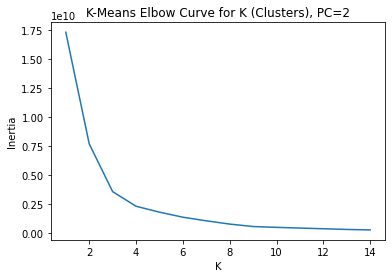

In [45]:
df_pca2=df[features3]


means=np.mean(df_pca2, axis=0)
std_devs=np.std(df_pca2, axis=0)
df_pca2=(df_pca2-means)/np.sqrt(std_devs)
pca2 = PCA(2)
df_pca2 = pca2.fit_transform(df_pca2)

distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_pca2)
    distortions.append(kmeanModel.inertia_)
    
plt.plot(K,distortions)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('K-Means Elbow Curve for K (Clusters), PC=2')






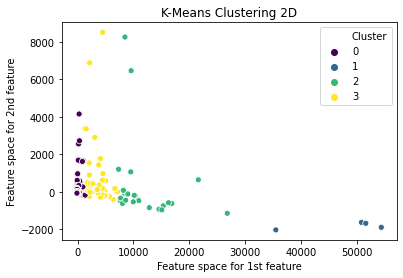

In [51]:
k=4
df_pca2 = pd.DataFrame(df_pca2, columns=['Feature space for 1st feature', 'Feature space for 2nd feature'])
kmeans = KMeans(n_clusters=k,algorithm='auto',init='k-means++',max_iter=300)
kmeans.fit_predict(df_pca2)
labels = kmeans.labels_
df_pca2['Cluster'] = labels
sns.scatterplot(x=df_pca2['Feature space for 1st feature'], y=df_pca2['Feature space for 2nd feature'], hue='Cluster', data=df_pca2, palette='viridis')
plt.title('K-Means Clustering 2D')

plt.show()

In [47]:
print("Explained Variance for Each Principal Component:")
for i, var in enumerate(pca2.explained_variance_ratio_):
    print(f"PC{i + 1}: {var:.2%}")
    
    
loadings_df = pd.DataFrame(pca2.components_.T, columns=[f'PC{i+1}' for i in range(pca2.n_components_)], index=df[features3].columns)

print("Loadings for PC:")
print(loadings_df[['PC1', 'PC2',]])


cluster_counts = Counter(labels)
percentages = {cluster: count / len(df) * 100 for cluster, count in cluster_counts.items()}
table_data = pd.DataFrame(list(percentages.items()), columns=['Cluster Label 2D', 'Percentage (%)'])
print(table_data)

Explained Variance for Each Principal Component:
PC1: 93.61%
PC2: 6.16%
Loadings for PC:
                    PC1       PC2
CPUTimeRAW     0.997821 -0.064111
ReqCPUS        0.001233  0.007418
AllocCPUS      0.001256  0.007446
ReqNodes       0.000084  0.000236
NNodes         0.000168  0.000692
total_minutes  0.011774 -0.000088
Timelimit_     0.010661  0.006689
ReqMem_MB      0.064019  0.997865
   Cluster Label 2D  Percentage (%)
0                 0       98.640600
1                 3        1.114148
2                 2        0.217224
3                 1        0.028029


[LightGBM] [Warning] Unknown parameter: colsample_by_tree


/mnt/home/arburyri/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for K-Means clusters is 0.9750452929026243
[LightGBM] [Warning] Unknown parameter: colsample_by_tree


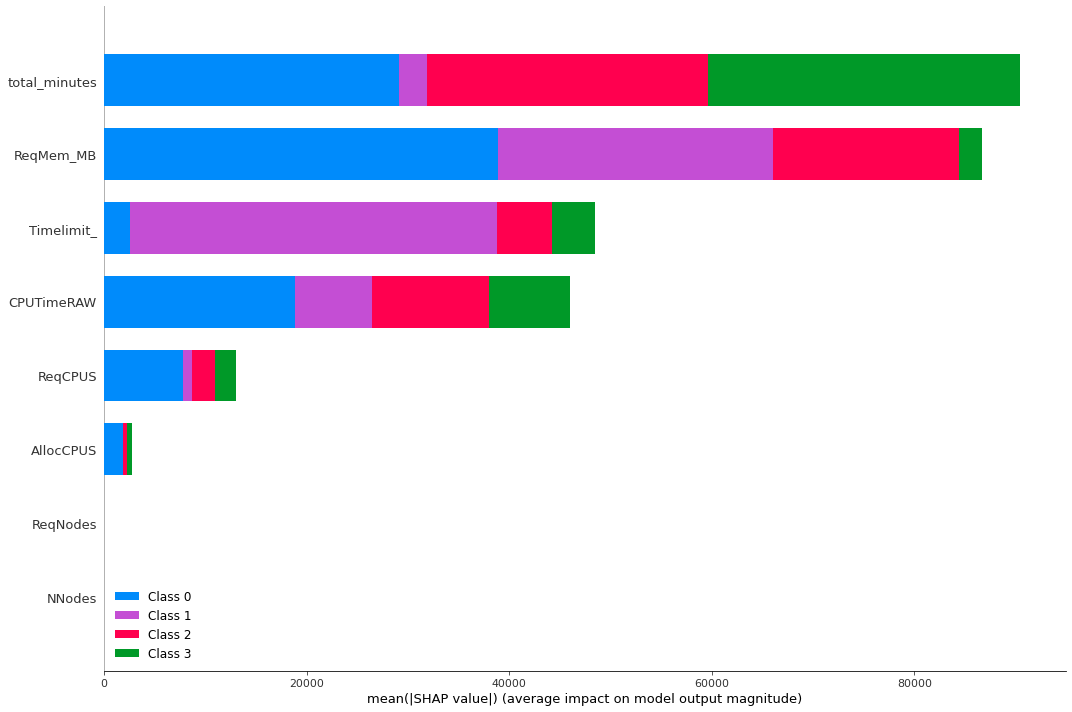

In [8]:
lgbm_data=df[features3]
for c in lgbm_data.select_dtypes(include='object'):
    lgbm_data[c] = lgbm_data[c].astype('category')
clf_km = LGBMClassifier(colsample_by_tree=0.8)
cv_scores_km = cross_val_score(clf_km, lgbm_data, labels, scoring='f1_weighted')
print(f'CV F1 score for K-Means clusters is {np.mean(cv_scores_km)}')


clf_km.fit(lgbm_data, labels)
explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km.shap_values(lgbm_data)
shap.summary_plot(shap_values_km, lgbm_data, plot_type="bar", plot_size=(15, 10))

Text(0.5, 1.0, 'K-Means Elbow Curve for K (Clusters), PC=3')

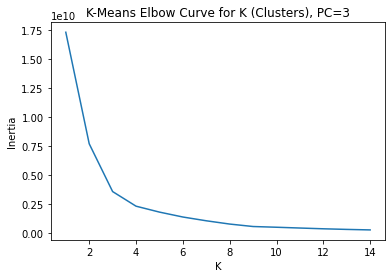

In [11]:
df_pca3=df[features3]


means=np.mean(df_pca3, axis=0)
std_devs=np.std(df_pca3, axis=0)
df_pca3=(df_pca3-means)/np.sqrt(std_devs)
pca3 = PCA(3)
df_pca3 = pca3.fit_transform(df_pca3)

distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_pca3)
    distortions.append(kmeanModel.inertia_)
    
plt.plot(K,distortions)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('K-Means Elbow Curve for K (Clusters), PC=3')

In [30]:
k = 4
df_pca3 = pd.DataFrame(df_pca3, columns=['1st feature', 
                                          '2nd feature',
                                          '3rd feature'])
kmeans = KMeans(n_clusters=k, algorithm='auto', init='k-means++', max_iter=300)
kmeans.fit_predict(df_pca3)
labels = kmeans.labels_
df_pca3['Cluster'] = labels
fig = px.scatter_3d(df_pca3, 
                    x='1st feature', 
                    y='2nd feature', 
                    z='3rd feature', 
                    color='Cluster',
                    opacity=0.7,
                    title='K-Means Clustering in 3D')




fig.show()

In [31]:
print("Explained Variance for Each Principal Component:")
for i, var in enumerate(pca3.explained_variance_ratio_):
    print(f"PC{i + 1}: {var:.2%}")
    
    
loadings_df = pd.DataFrame(pca3.components_.T, columns=[f'PC{i+1}' for i in range(pca3.n_components_)], index=df[features3].columns)

print("Loadings for PC:")
print(loadings_df[['PC1', 'PC2','PC3']])


cluster_counts = Counter(labels)
percentages = {cluster: count / len(df) * 100 for cluster, count in cluster_counts.items()}
table_data = pd.DataFrame(list(percentages.items()), columns=['Cluster Label 3D', 'Percentage (%)'])
print(table_data)

Explained Variance for Each Principal Component:
PC1: 93.61%
PC2: 6.16%
PC3: 0.20%
Loadings for PC:
                    PC1       PC2       PC3
CPUTimeRAW     0.997821 -0.064111  0.014058
ReqCPUS        0.001233  0.007418 -0.001474
AllocCPUS      0.001256  0.007446 -0.001367
ReqNodes       0.000084  0.000236 -0.000007
NNodes         0.000168  0.000692  0.000811
total_minutes  0.011774 -0.000088 -0.399281
Timelimit_     0.010661  0.006689 -0.916691
ReqMem_MB      0.064019  0.997865  0.007034
   Cluster Label 3D  Percentage (%)
0                 0       98.640600
1                 3        1.114148
2                 2        0.217224
3                 1        0.028029


[LightGBM] [Warning] Unknown parameter: colsample_by_tree


/mnt/home/arburyri/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for K-Means clusters is 0.9811053592312862
[LightGBM] [Warning] Unknown parameter: colsample_by_tree


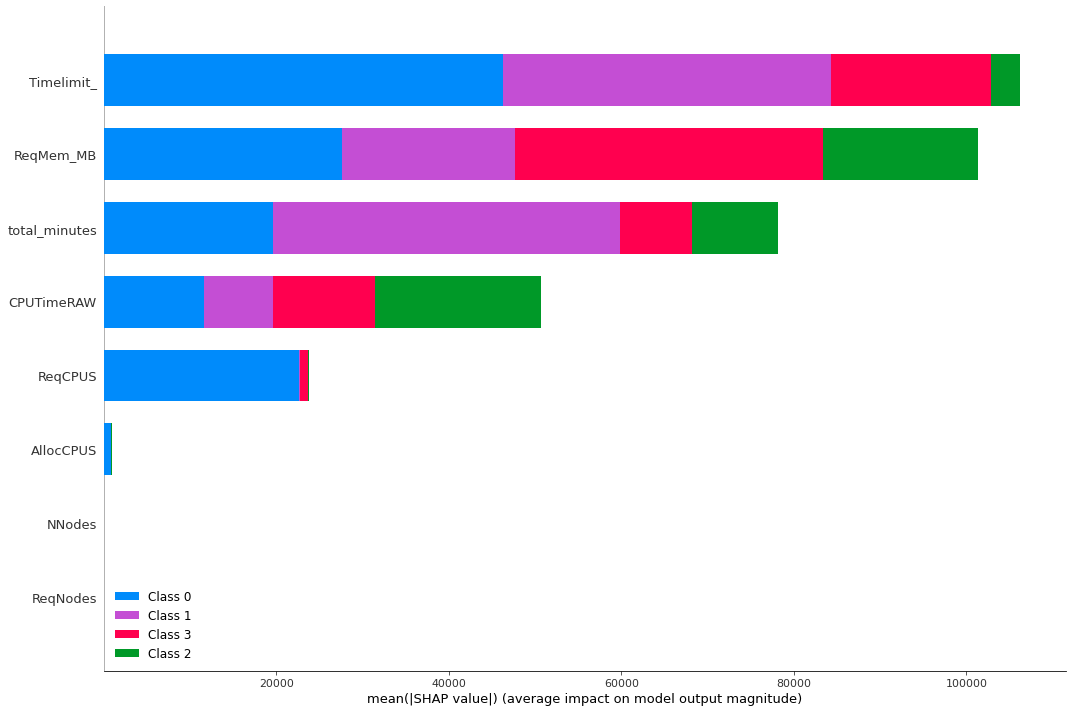

In [12]:
lgbm_data=df[features3]
for c in lgbm_data.select_dtypes(include='object'):
    lgbm_data[c] = lgbm_data[c].astype('category')
clf_km = LGBMClassifier(colsample_by_tree=0.8)
cv_scores_km = cross_val_score(clf_km, lgbm_data, labels, scoring='f1_weighted')
print(f'CV F1 score for K-Means clusters is {np.mean(cv_scores_km)}')


clf_km.fit(lgbm_data, labels)
explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km.shap_values(lgbm_data)
shap.summary_plot(shap_values_km, lgbm_data, plot_type="bar", plot_size=(15, 10))

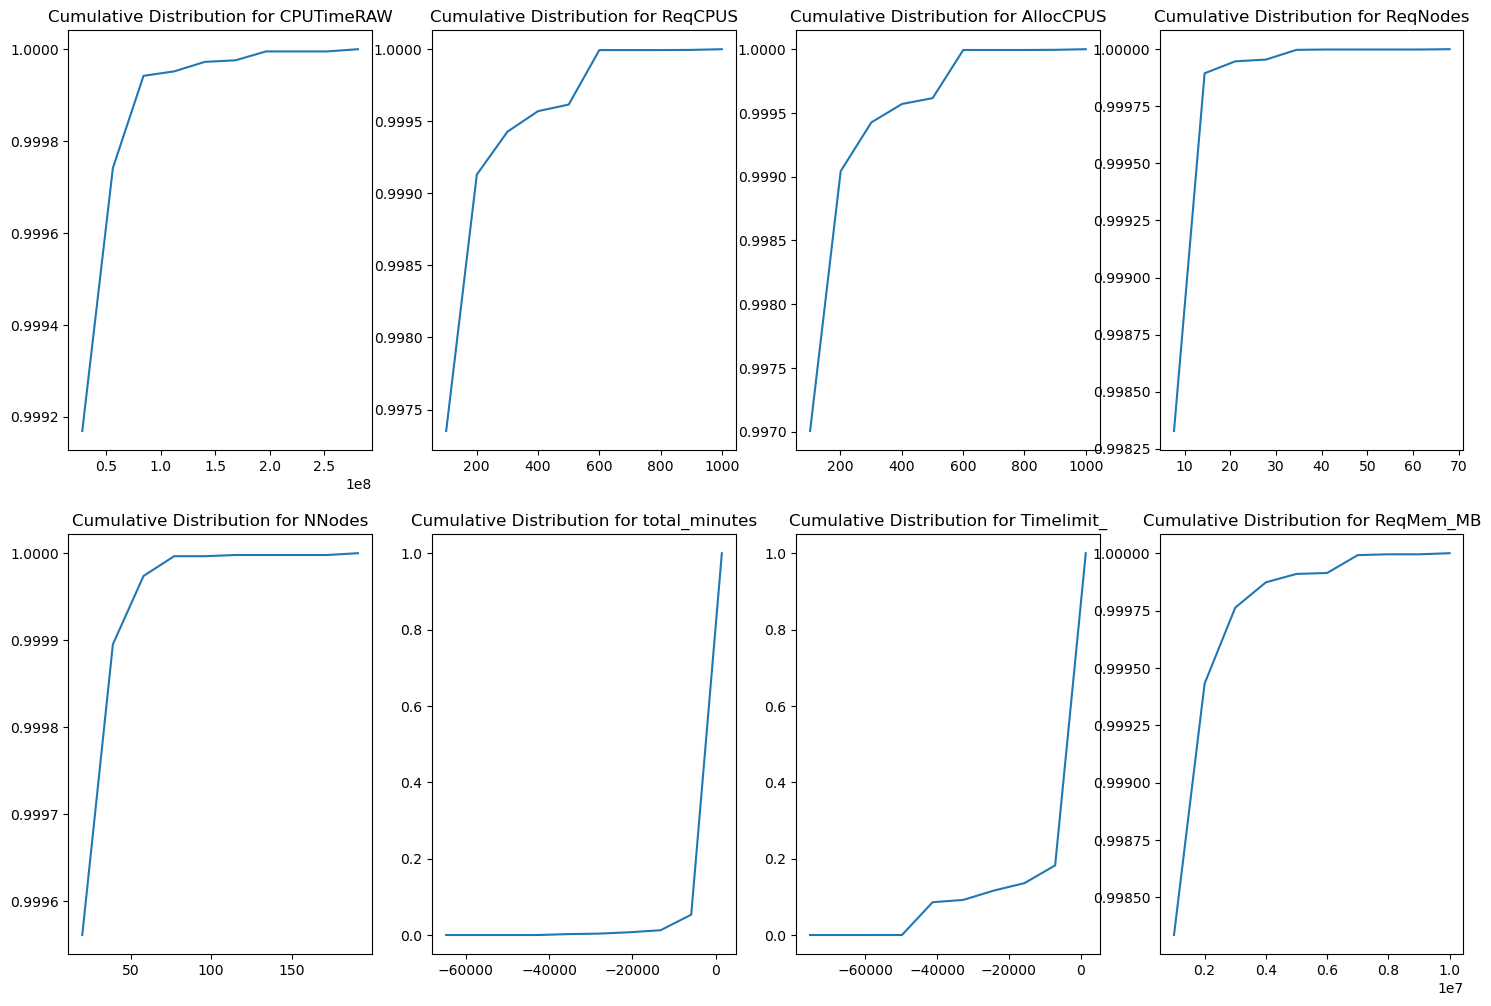

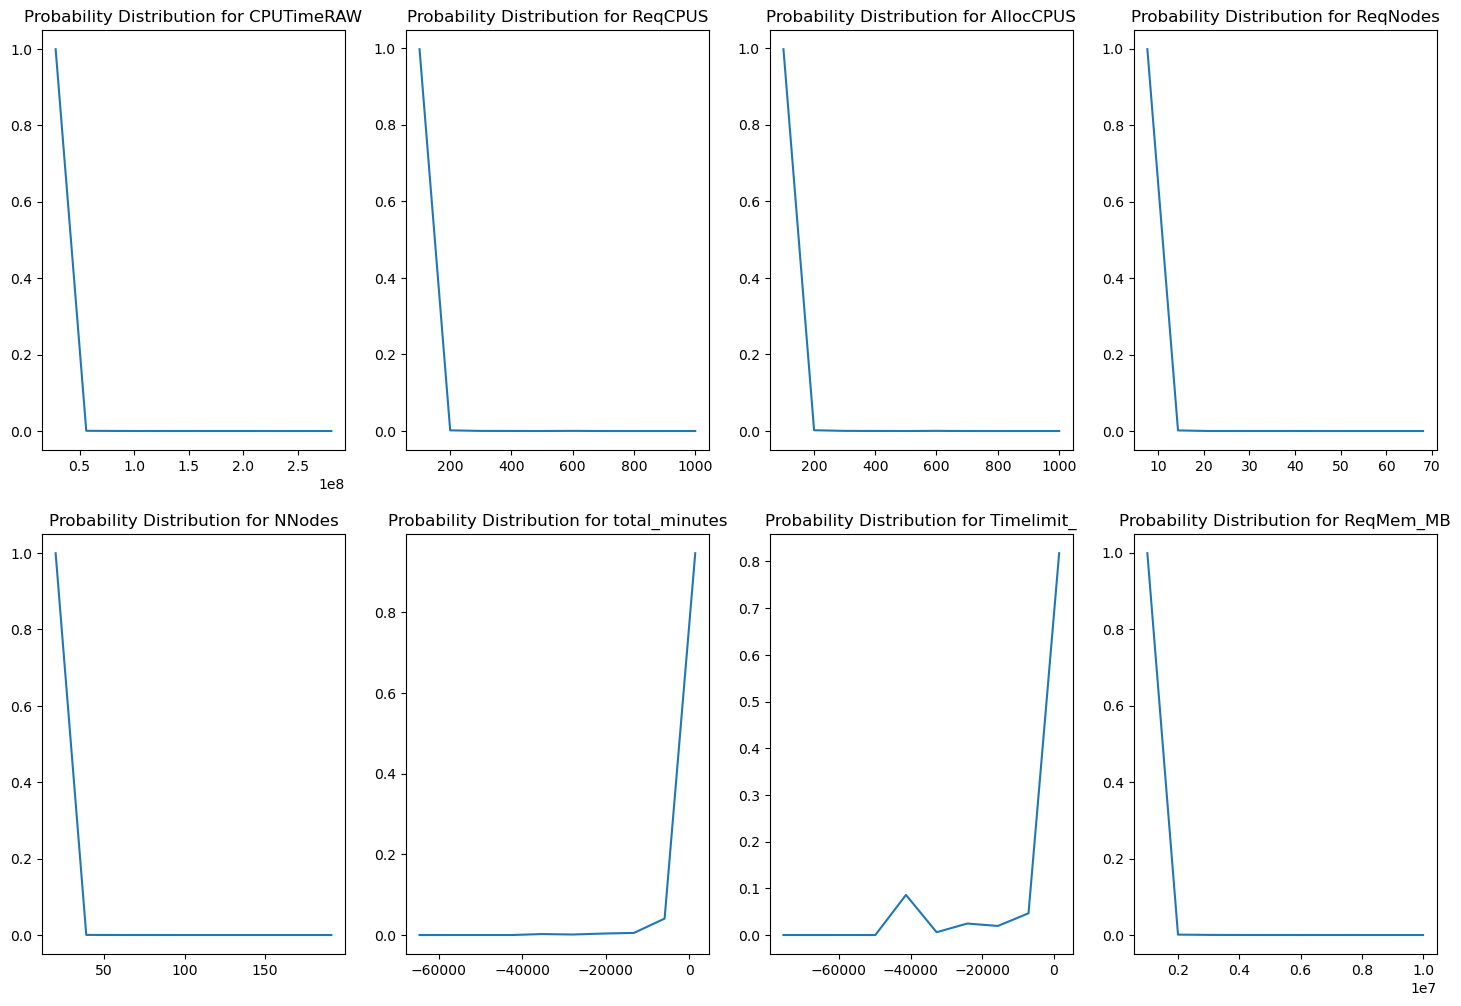

In [11]:
fig, axs = plt.subplots(2, 4, figsize=(18, 12))
for i, feature in enumerate(features3):
    ax = axs[i // 4, i % 4]
    values, base = np.histogram(df[feature])
    pdf = values / sum(values)
    cdf = np.cumsum(pdf)
    ax.plot(base[1:], cdf)
    ax.set_title(f'Cumulative Distribution for {feature}')

fig, axs = plt.subplots(2, 4, figsize=(18, 12))
for i, feature in enumerate(features3):
    ax = axs[i // 4, i % 4]
    values, base = np.histogram(df[feature])
    pdf = values / sum(values)
    ax.plot(base[1:], pdf)
    ax.set_title(f'Probability Distribution for {feature}')

plt.show()

In [14]:
df[['UserCPU','SystemCPU','TotalCPU','CPUTime','CPUTimeRAW']]

,UserCPU,SystemCPU,TotalCPU,CPUTime,CPUTimeRAW
0,02:05.866,00:05.200,02:11.066,00:02:38,158
1,00:09.628,00:02.118,00:11.747,00:00:48,48
2,01:00.685,00:05.429,01:06.114,00:02:02,122
3,02:12.142,00:05.168,02:17.311,00:03:00,180
4,00:09.881,00:02.815,00:12.696,00:01:05,65
...,...,...,...,...,...
14266,15:15.826,12:12.971,27:28.797,00:28:12,1692
14267,15:10.246,12:11.760,27:22.006,00:28:16,1696
14268,13:44.736,10:47.277,24:32.013,00:25:04,1504
14269,25:55.430,17:10.054,43:05.484,00:45:52,2752


In [32]:
problematic_values = df.loc[pd.to_timedelta("00:" + df['TotalCPU'], errors='coerce').isnull(), 'TotalCPU']

print("Problematic values in 'TotalCPU' column:")
print(problematic_values)


Problematic values in 'TotalCPU' column:
43       01:00:50
49       02:36:04
120      02:02:30
121      02:59:30
122      02:43:41
           ...   
14251    17:50:47
14252    16:00:56
14253    21:07:48
14254    19:46:44
14255    09:15:53
Name: TotalCPU, Length: 7307, dtype: object


In [33]:
df[['MaxRSS_MB']]
nan_count = df['MaxRSS_MB'].isna().sum()
null_count = df['MaxRSS_MB'].isnull().sum()

print("Number of NaNs in 'MaxRSS_MB' column:", nan_count)
print("Number of null values in 'MaxRSS_MB' column:", null_count)


Number of NaNs in 'MaxRSS_MB' column: 265
Number of null values in 'MaxRSS_MB' column: 265


In [34]:
df.dtypes

Unnamed: 0                 int64
JobID                      int64
User                      object
Group                     object
Submit                    object
Start                     object
End                       object
Elapsed                   object
State                     object
Account                   object
AssocID                   object
Partition                 object
Timelimit                 object
UserCPU                   object
SystemCPU                 object
TotalCPU                  object
CPUTime                   object
CPUTimeRAW                 int64
ReqCPUS                    int64
AllocCPUS                  int64
ReqMem                    object
MaxRSS                    object
ReqNodes                   int64
NNodes                     int64
NodeList                  object
ReqTRES                   object
AllocTRES                 object
ReqMem_MB                float64
MaxRSS_MB                float64
Timelimit_               float64
time_colum

In [52]:
df_pca2

,Feature space for 1st feature,Feature space for 2nd feature,Cluster
0,-113.151,-58.9522,0
1,-113.255,-58.9456,0
2,-113.185,-58.9501,0
3,-113.131,-58.9536,0
4,-113.239,-58.9466,0
...,...,...,...
14266,-111.841,-65.9196,0
14267,-111.837,-65.9198,0
14268,-112.018,-65.9083,0
14269,-110.846,-65.9834,0


In [53]:
y=df['Group']
df_pca2['Group']=y
df_pca2 = df_pca2.drop(df_pca2.index[-1])
df_pca2

,Feature space for 1st feature,Feature space for 2nd feature,Cluster,Group
0,-113.151,-58.9522,0,group_009
1,-113.255,-58.9456,0,group_009
2,-113.185,-58.9501,0,group_009
3,-113.131,-58.9536,0,group_009
4,-113.239,-58.9466,0,group_009
...,...,...,...,...
14265,-111.097,-65.9673,0,group_062
14266,-111.841,-65.9196,0,group_062
14267,-111.837,-65.9198,0,group_062
14268,-112.018,-65.9083,0,group_062


In [54]:
group_count_per_cluster = df_pca2.groupby(['Cluster', 'Group']).size().unstack(fill_value=0)
percentage_breakdown = group_count_per_cluster.div(group_count_per_cluster.sum(axis=1), axis=0) * 100
print(percentage_breakdown)

Group    group_000  group_002  group_003  group_004  group_008  group_009  \
Cluster                                                                     
0         0.795681   1.790281   0.838306   2.855925   1.143791  12.603012   
1         0.000000   0.000000  25.000000   0.000000   0.000000   0.000000   
2         6.451613   0.000000  41.935484   0.000000   0.000000   0.000000   
3        16.981132   0.000000   2.515723   0.000000   0.000000   0.000000   

Group    group_015  group_018  group_019  group_021  ...  group_131  \
Cluster                                              ...              
0         0.007104   0.063939   0.007104   0.000000  ...    0.09946   
1         0.000000   0.000000   0.000000   0.000000  ...    0.00000   
2         0.000000   0.000000   0.000000   0.000000  ...    0.00000   
3         0.000000   0.000000   0.000000   1.257862  ...    0.00000   

Group    group_132  group_133  group_136  group_138  group_139  group_140  \
Cluster                          

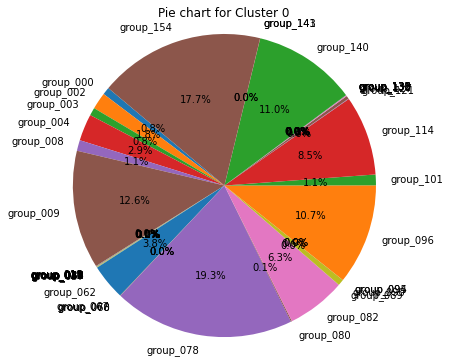

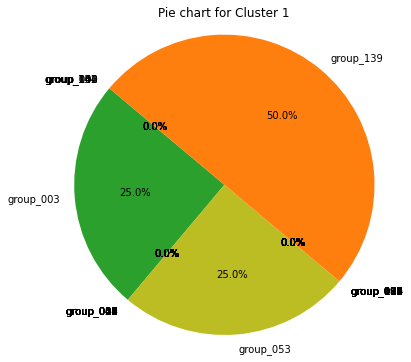

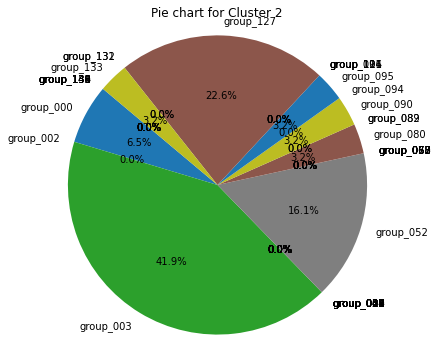

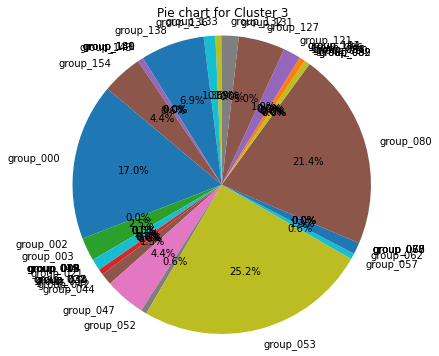

In [55]:
num_clusters = len(percentage_breakdown)
for cluster in range(num_clusters):
    data = percentage_breakdown.loc[cluster]
    plt.figure(figsize=(6, 6))
    plt.pie(data, labels=data.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Pie chart for Cluster {cluster}')
    plt.axis('equal')  
    plt.show()

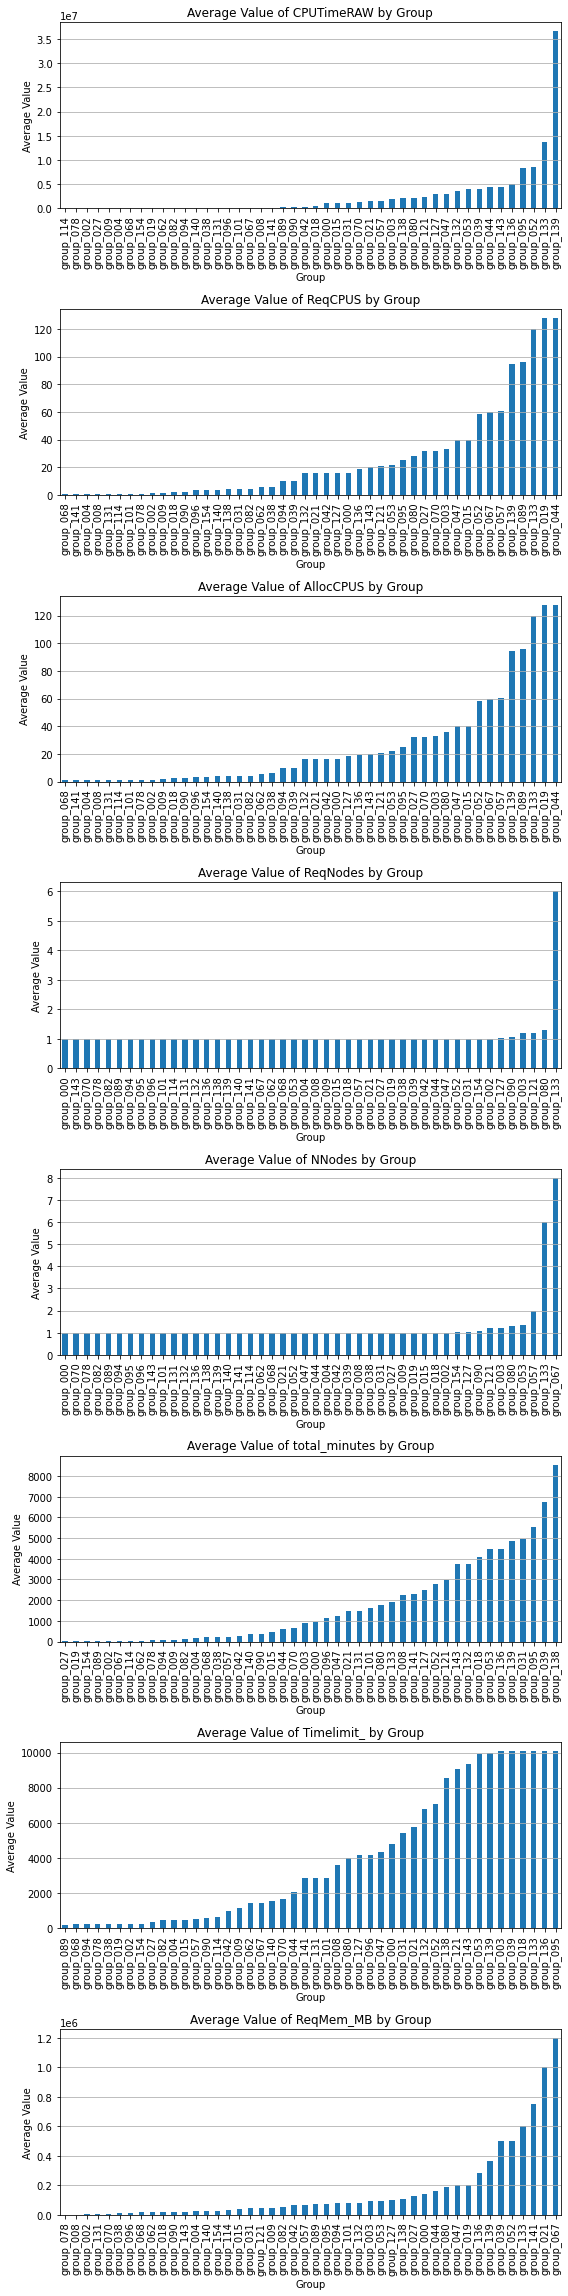

In [18]:
num_features = len(features3)
fig, axs = plt.subplots(num_features, 1, figsize=(8, 4*num_features))

for i, feature in enumerate(features3):
    average_by_group = df.groupby('Group')[feature].mean()
    average_by_group_sorted = average_by_group.sort_values()
    
    ax = axs[i]
    average_by_group_sorted.plot(kind='bar', ax=ax)
    ax.set_title(f'Average Value of {feature} by Group')
    ax.set_xlabel('Group')
    ax.set_ylabel('Average Value')
    ax.grid(axis='y')  
    
plt.tight_layout()
plt.show()


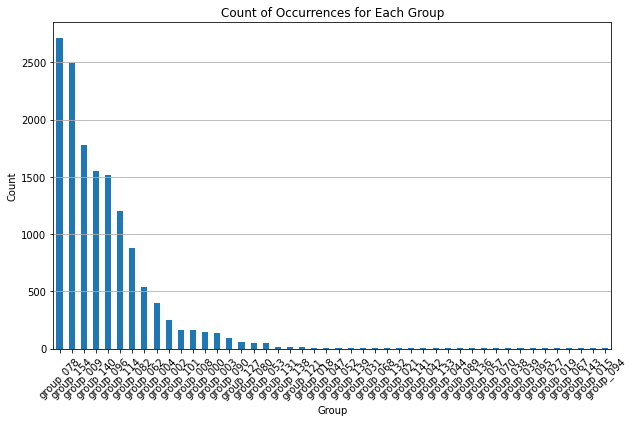

In [19]:
group_counts = df['Group'].value_counts()
plt.figure(figsize=(10, 6))
group_counts.plot(kind='bar')
plt.title('Count of Occurrences for Each Group')
plt.xlabel('Group')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.grid(axis='y')  
plt.show()